# Librairies

In [1]:
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
from jax import jit
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA, KernelPCA
import time
from IPython.display import clear_output, display
import tensorflow as tf
import torchvision.datasets as datasets

import flax
import optax
import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence
from ott.tools import plot

import ot
import ot as pot

import torchdyn
from torchdyn.core import NeuralODE

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler

from src.icnn import ICNN, sampler_from_data
from src.ot_solver import OT_Solver
from src.sinkhorn_loss import sinkhorn_loss
from src.plotdataset import plot_dataset
from src.mini_batch_ot import mini_batch, update_plan, compute_incomplete_plan

# Import MNIST and USPS images

In [2]:
#MNIST
(img_mnist, labels_mnist), _ = tf.keras.datasets.mnist.load_data()
##Resize from 28*28 to 16*16
transform = torchvision.transforms.Resize((16,16))
img_mnist = np.array(transform(torch.tensor(img_mnist)))
##Normalize and flatten
img_mnist = np.array([elt.reshape(16*16).astype(float)/255.0 for elt in img_mnist])
##Take only 10,000 images
img_mnist, _, labels_mnist, _ = train_test_split(img_mnist,
                                                 labels_mnist,
                                                 stratify = labels_mnist, 
                                                 train_size = 10000,
                                                 random_state = 123)


#USPS
usps_trainset = datasets.USPS(root='./data', train=True, download=True, transform=None)
##Normalize and flatten
img_usps = np.array([elt.reshape(16*16).astype(float)/255.0 for elt in usps_trainset.data])
labels_usps = np.array(usps_trainset.targets)

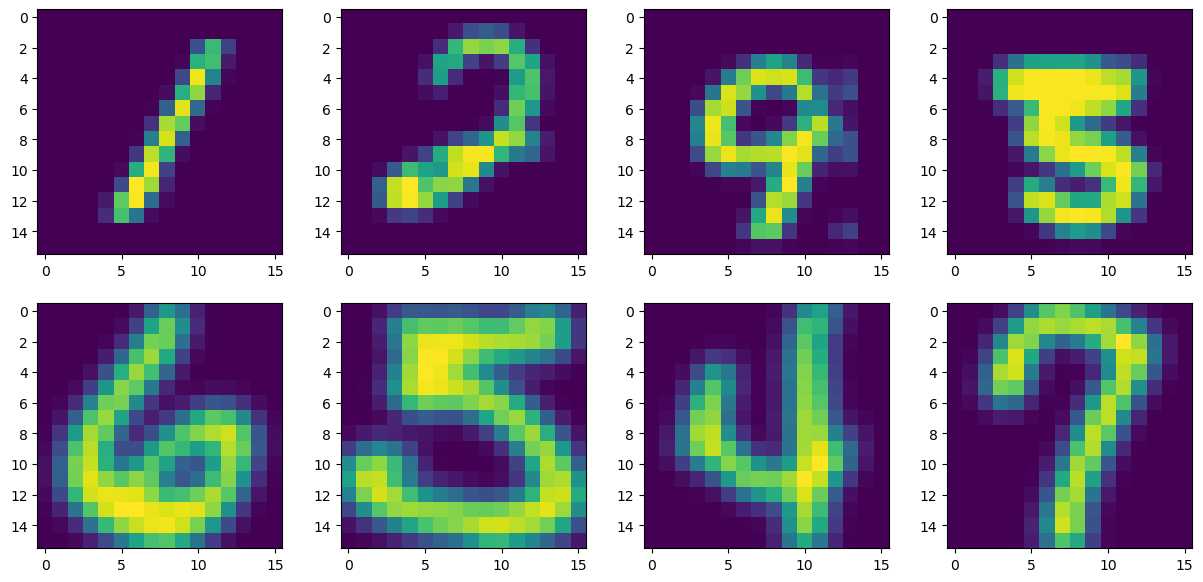

In [26]:
fig, axs = plt.subplots(2, 4, figsize=(15, 7))

axs[0,0].imshow(img_mnist[0].reshape(16, 16))
axs[0,1].imshow(img_mnist[1].reshape(16, 16))
axs[0,2].imshow(img_mnist[2].reshape(16, 16))
axs[0,3].imshow(img_mnist[3].reshape(16, 16))

axs[1,0].imshow(img_usps[0].reshape(16, 16))
axs[1,1].imshow(img_usps[1].reshape(16, 16))
axs[1,2].imshow(img_usps[2].reshape(16, 16))
axs[1,3].imshow(img_usps[3].reshape(16, 16))
plt.show()

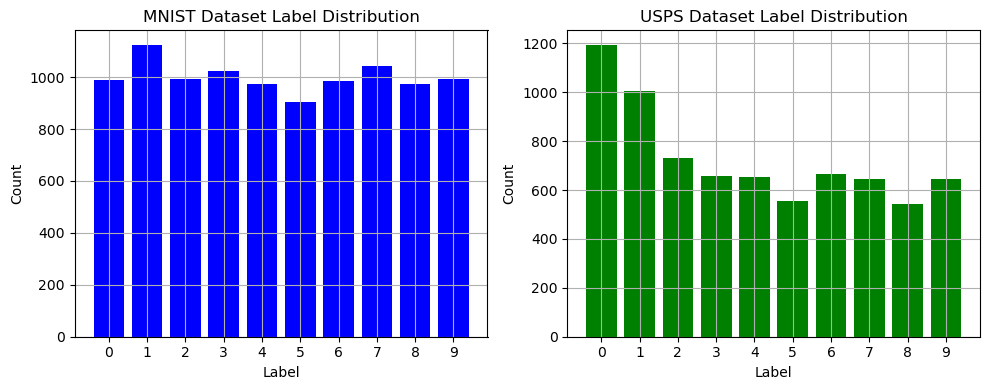

In [27]:
mnist_label_counts = np.bincount(labels_mnist)
mnist_num_classes = len(mnist_label_counts)

usps_label_counts = np.bincount(labels_usps)
usps_num_classes = len(usps_label_counts)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(mnist_num_classes), mnist_label_counts, color='blue')
plt.title('MNIST Dataset Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(range(mnist_num_classes))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(range(usps_num_classes), usps_label_counts, color='green')
plt.title('USPS Dataset Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(range(usps_num_classes))
plt.grid(True)

plt.tight_layout()
plt.show()

In [3]:
X = jnp.array(img_mnist) #X: MNIST (source distribution)
Y = jnp.array(img_usps)  #Y: USPS (target distribution)

# Label annotation

## Entropic Map

In [4]:
reg_list = [1, 10, 100]

for i, reg in enumerate(reg_list):
    print("Entropic OT plan (reg:{})".format(reg))
    geom = ott.geometry.pointcloud.PointCloud(X, Y, epsilon = reg)    # Define an euclidean geometry
    problem = ott.problems.linear.linear_problem.LinearProblem(geom)  # Define your problem
    solver = ott.solvers.linear.sinkhorn.Sinkhorn()                   # Select the Sinkhorn solver

    out = solver(problem)                                             # Solve it !

    f = out.f                                                         # Get back the potentials f and g
    g = out.g

    # Define entropic map with the output of the solver
    entropic_map = out.to_dual_potentials()
    # Transport X with this map
    transported_samples_entropic = entropic_map.transport(X)
    # Compute Sinkhorn distance
    sinkhorn_div_entropic = sinkhorn_loss(transported_samples_entropic, Y)
    print(f"Sinkhorn distance - Entropic Map (reg={reg}): {sinkhorn_div_entropic:.2f}")
    # Compute overall distance
    dist_entropic = entropic_map.distance(X, Y)
    print(f"Entropic dual distance (reg={reg}): {dist_entropic:.2f}")
    
    clf = SVC()
    clf.fit(transported_samples_entropic, labels_mnist)
    labels_usps_pred = clf.predict(img_usps)
    print("Accuracy - reg = {}: {}".format(reg, accuracy_score(labels_usps, labels_usps_pred)))
    print("Balanced accuracy - reg = {}: {}\n".format(reg, balanced_accuracy_score(labels_usps, labels_usps_pred)))

Entropic OT plan (reg:1)
Sinkhorn distance - Entropic Map (reg=1): 4.51
Entropic dual distance (reg=1): 46.07
Accuracy - reg = 1: 0.5571252228775202
Balanced accuracy - reg = 1: 0.5266184612765231

Entropic OT plan (reg:10)
Sinkhorn distance - Entropic Map (reg=10): 12.71
Entropic dual distance (reg=10): 215.52
Accuracy - reg = 10: 0.26608147030585655
Balanced accuracy - reg = 10: 0.23455295762948705

Entropic OT plan (reg:100)
Sinkhorn distance - Entropic Map (reg=100): 16.05
Entropic dual distance (reg=100): 1846.26
Accuracy - reg = 100: 0.417501028665478
Balanced accuracy - reg = 100: 0.341317854952724



## ICNN

In [4]:
sampler_source_train = sampler_from_data(X)
sampler_target_train = sampler_from_data(Y)

In [5]:
%%time
icnn = ICNN(dim_hidden=[64,64,64,64])
optimizer = optax.adam(learning_rate=1e-3)

# Set input dimensions
input_dim = img_mnist.shape[1]
# Set the number of steps
num_train_iters = 10000
batch_size = 64

# Setup the solver
solver = OT_Solver(
    input_dim = input_dim,
    neural_net = icnn,
    optimizer = optimizer,
    num_train_iters = num_train_iters
)

# Launch the train !
OT_state = solver(
    sampler_source = sampler_source_train,
    sampler_target = sampler_target_train,
    size_batch_train = batch_size
)

loss After 0 Iterations : 640.619568
loss After 100 Iterations : 26.999846
loss After 200 Iterations : 23.026226
loss After 300 Iterations : 15.815948
loss After 400 Iterations : 14.340771
loss After 500 Iterations : 13.781010
loss After 600 Iterations : 12.092882
loss After 700 Iterations : 11.487598
loss After 800 Iterations : 11.674707
loss After 900 Iterations : 10.783405
loss After 1000 Iterations : 11.151790
loss After 1100 Iterations : 11.880774
loss After 1200 Iterations : 10.949327
loss After 1300 Iterations : 10.981570
loss After 1400 Iterations : 10.116693
loss After 1500 Iterations : 10.209395
loss After 1600 Iterations : 11.215869
loss After 1700 Iterations : 10.345378
loss After 1800 Iterations : 11.100197
loss After 1900 Iterations : 9.805384
loss After 2000 Iterations : 9.356792
loss After 2100 Iterations : 9.892092
loss After 2200 Iterations : 10.300430
loss After 2300 Iterations : 7.949848
loss After 2400 Iterations : 11.040592
loss After 2500 Iterations : 9.196578
lo

In [6]:
predict = OT_state.apply_fn
params = OT_state.params

# Extract the ot map from predict
ot_map_point = jax.grad(predict, argnums=1)

# Use vmap to vectorize the ot_map
ot_map = jax.vmap(lambda x: ot_map_point({'params': params}, x))

# Get the prediction
transported_samples_icnn = ot_map(X)

In [8]:
sinkhorn_div_icnn = sinkhorn_loss(transported_samples_icnn, Y)
print(f"Sinkhorn distance - (ICNN): {sinkhorn_div_icnn:.2f}")

Sinkhorn distance - (ICNN): 6.39


In [40]:
clf = SVC()
clf.fit(transported_samples_icnn, labels_mnist)
labels_usps_pred= clf.predict(img_usps)

print("Accuracy: {}".format(accuracy_score(labels_usps, labels_usps_pred)))
print("Balanced accuracy: {}".format(balanced_accuracy_score(labels_usps, labels_usps_pred)))

Accuracy: 0.5646687697160884
Balanced accuracy: 0.541072046454511


# Conditional Flow Matching

In [5]:
X_tensor = torch.tensor(img_mnist, dtype = torch.float32)
Y_tensor = torch.tensor(img_usps, dtype= torch.float32)

In [42]:
%%time
sigma = 0.1
dim = X_tensor.shape[1]
model = MLP(dim = dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)
n_epochs = 5000
batch_size = 64
min_samples_x_y = np.min((X_tensor.shape[0], Y_tensor.shape[0]))

for k in range(n_epochs):
    num_batch_img = 0
    while num_batch_img < min_samples_x_y:
        random_ind_x = torch.randperm(X_tensor.size(0))[:batch_size]
        random_ind_y = torch.randperm(Y_tensor.size(0))[:batch_size]

        optimizer.zero_grad()
        t, xt, ut = FM.sample_location_and_conditional_flow(X_tensor[random_ind_x], Y_tensor[random_ind_y])
        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        num_batch_img+=batch_size
        
    if (k + 1) % 1000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f}")
        start = end
        node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
        with torch.no_grad():
            traj = node.trajectory(
                X_tensor,
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())

clear_output()

CPU times: total: 2h 1min 9s
Wall time: 23min 32s


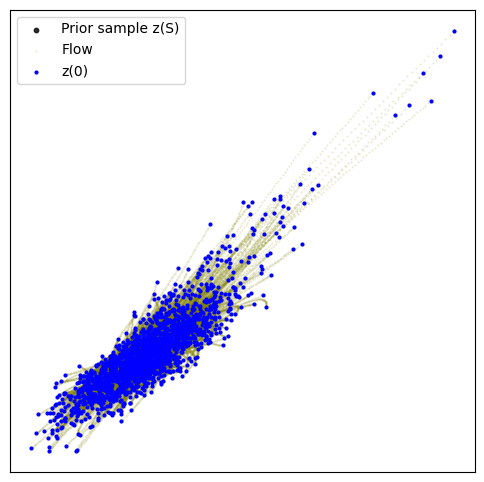

Sinkhorn distance between target predictions and data samples: 9.87


In [43]:
transported_samples_conditionnal_flow = node.trajectory(x=X_tensor, t_span=torch.linspace(0, 1, 100))

## Plot OT map
plot_trajectories(transported_samples_conditionnal_flow.detach().numpy())
## Compute Sinkhorn distance
sinkhorn_div_conditional_flow = sinkhorn_loss(jnp.array(transported_samples_conditionnal_flow[-1].detach().numpy()), Y)
print(f"Sinkhorn distance between target predictions and data samples: {sinkhorn_div_conditional_flow:.2f}")

In [44]:
clf = SVC()
clf.fit(transported_samples_conditionnal_flow[-1].detach().numpy(), labels_mnist)
labels_usps_pred= clf.predict(img_usps)

print("Accuracy: {}".format(accuracy_score(labels_usps, labels_usps_pred)))
print("Balanced accuracy: {}".format(balanced_accuracy_score(labels_usps, labels_usps_pred)))

Accuracy: 0.32615553422027155
Balanced accuracy: 0.3220048377553189


# Mini-batch OT

In [6]:
# We pre-compute the ground cost matrix
M = torch.cdist(X_tensor, Y_tensor) ** 2

ot_plan_list = []
num_iter = 5000
a, b = ot.unif(X_tensor.shape[0]), ot.unif(Y_tensor.shape[0])

ot_sampler = OTPlanSampler(method="exact")
pi = ot_sampler.get_map(X_tensor, Y_tensor)
ot_plan_list.append(pi)

# Compuete incomplete mbot plan for several batch sizes
batch_size_list = [128, 64]

for i, batch_size in enumerate(batch_size_list):
    incomplete_mbot_plan = compute_incomplete_plan(X_tensor, Y_tensor, a, b, batch_size, num_iter, M.numpy())
    ot_plan_list.append(incomplete_mbot_plan)

c:\Users\yanis\anaconda3\Lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


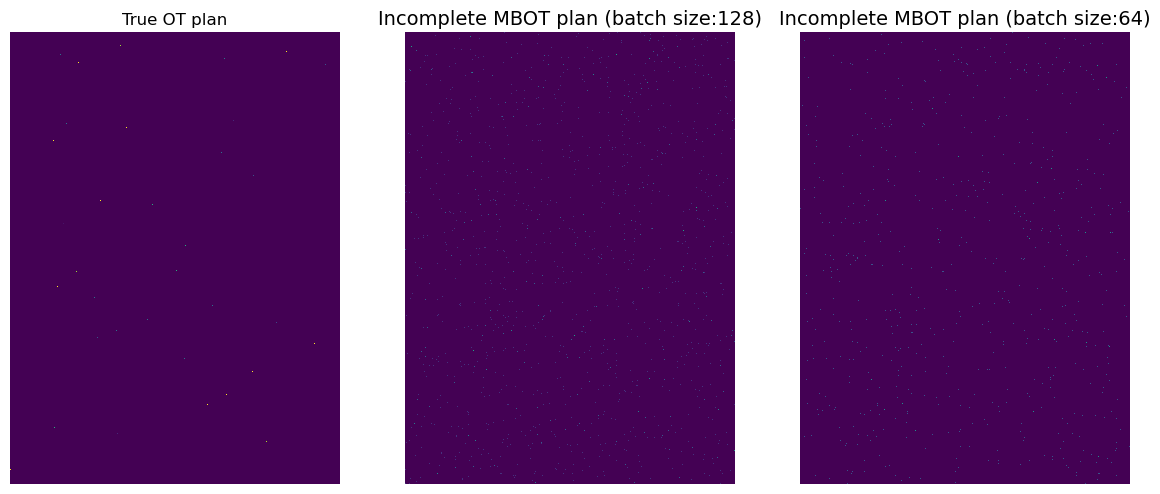

In [7]:
plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(ot_plan_list[0], interpolation="nearest")
ax1.axis("off")
ax1.set_title("True OT plan")

for i in range(2):
    ax = plt.subplot(1, 3, i + 2)
    ax.imshow(ot_plan_list[i + 1], interpolation="nearest")
    ax.axis("off")
    batch_size = batch_size_list[i]
    ax.set_title("Incomplete MBOT plan (batch size:{})".format(batch_size), fontsize=14)

plt.tight_layout()
plt.show()

5000: loss 0.028
Sinkhorn distance - OT-CFM trained with true OT plan: 7.67
5000: loss 0.036
Sinkhorn distance - OT-CFM trained w. MBOT (size:128): 8.01


<timed exec>:68: UserWarning: The figure layout has changed to tight


5000: loss 0.036
Sinkhorn distance - OT-CFM trained w. MBOT (size:128): 8.10
CPU times: total: 7h 24min 47s
Wall time: 4h 21min 44s


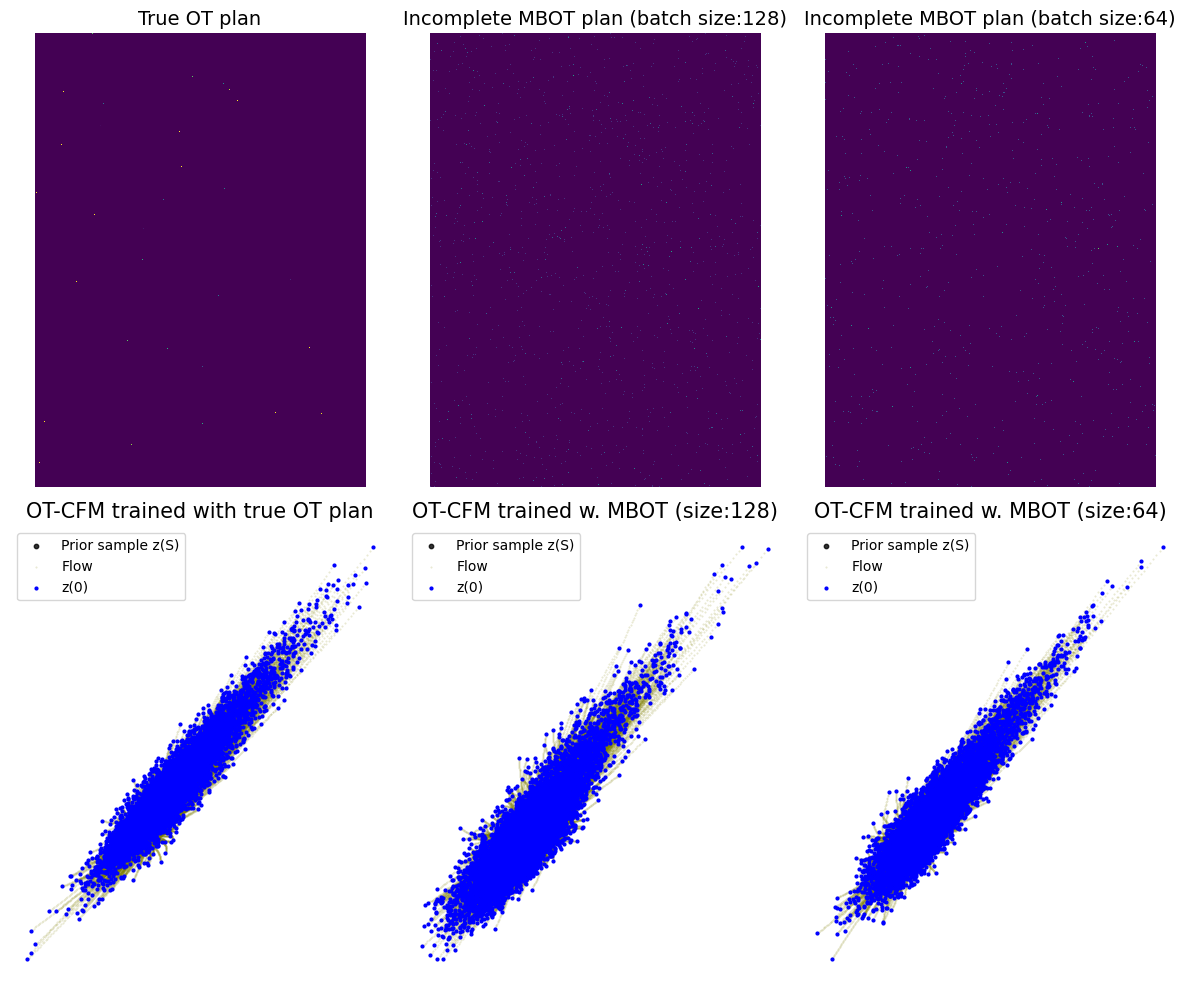

In [8]:
%%time
sigma = 0.1
dim = X_tensor.shape[1]
plt.figure(3, figsize=(12, 10))
batch_size = 128
n_epochs = 5000

list_transported_samples_minibatch_ot = []

for i, mbot_plan in enumerate(ot_plan_list):
    model = MLP(dim = dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)

    ot_sampler = OTPlanSampler(method="exact")

    for k in range(n_epochs):
        optimizer.zero_grad()

        indices_i, indices_j = ot_sampler.sample_map(mbot_plan, batch_size=batch_size, replace=False)
        batch_x0, batch_x1 = X_tensor[indices_i], Y_tensor[indices_j]
        t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)
        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

    print(f"{k+1}: loss {loss.item():0.3f}")
    node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    with torch.no_grad():
        traj = node.trajectory(
            X_tensor,
            t_span=torch.linspace(0, 1, 100),
        )
        
        sinkhorn_div = sinkhorn_loss(jnp.array(traj[-1].detach().numpy()), Y)
        if i == 0:
          print(f"Sinkhorn distance - OT-CFM trained with true OT plan: {sinkhorn_div:.2f}")
        else:
          print(f"Sinkhorn distance - OT-CFM trained w. MBOT (size:{batch_size}): {sinkhorn_div:.2f}")
          
        plt.subplot(2, 3, i + 1)
        plt.imshow(ot_plan_list[i], interpolation="nearest")
        plt.axis("off")
        if i == 0:
            plt.title("True OT plan", fontsize=14)
        else:
            batch_size = batch_size_list[i - 1]
            plt.title("Incomplete MBOT plan (batch size:{})".format(batch_size), fontsize=14)

        plt.subplot(2, 3, i + 4)
        traj = traj.cpu().numpy()
        list_transported_samples_minibatch_ot.append(traj[-1])
        plt.scatter(
            traj[0, :X_tensor.shape[0], 0], traj[0, :X_tensor.shape[0], 1], s=10, alpha=0.8, c="black"
        )
        plt.scatter(
            traj[:, :X_tensor.shape[0], 0], traj[:, :X_tensor.shape[0], 1], s=0.2, alpha=0.2, c="olive"
        )
        plt.scatter(traj[-1, :X_tensor.shape[0], 0], traj[-1, :X_tensor.shape[0], 1], s=4, alpha=1, c="blue")
        plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
        if i == 0:
            plt.title("OT-CFM trained with true OT plan", fontsize=15)
        else:
            plt.title("OT-CFM trained w. MBOT (size:{})".format(batch_size), fontsize=15)
        plt.tight_layout()

In [9]:
for i, transported_samples in enumerate(list_transported_samples_minibatch_ot):
    clf = SVC()
    clf.fit(transported_samples, labels_mnist)
    labels_usps_pred = clf.predict(img_usps)

    if i == 0:
        print("Accuracy: {} - OT-CFM trained with true OT plan".format(accuracy_score(labels_usps, labels_usps_pred)))
        print("Balanced accuracy: {} - OT-CFM trained with true OT plan".format(balanced_accuracy_score(labels_usps, labels_usps_pred)))
    
    elif i == 1:
        print("Accuracy: {} - OT-CFM trained w. MBOT (size:64)".format(accuracy_score(labels_usps, labels_usps_pred)))
        print("Balanced accuracy: {} - OT-CFM trained w. MBOT (size:64)".format(balanced_accuracy_score(labels_usps, labels_usps_pred)))
    else:
        print("Accuracy: {} - OT-CFM trained w. MBOT (size:128)".format(accuracy_score(labels_usps, labels_usps_pred)))
        print("Balanced accuracy: {} - OT-CFM trained w. MBOT (size:128)".format(balanced_accuracy_score(labels_usps, labels_usps_pred)))

Accuracy: 0.6498422712933754 - OT-CFM trained with true OT plan
Balanced accuracy: 0.6358393772035813 - OT-CFM trained with true OT plan
Accuracy: 0.6056782334384858 - OT-CFM trained w. MBOT (size:64)
Balanced accuracy: 0.5854869408977436 - OT-CFM trained w. MBOT (size:64)
Accuracy: 0.58469345768756 - OT-CFM trained w. MBOT (size:128)
Balanced accuracy: 0.5657875446776659 - OT-CFM trained w. MBOT (size:128)


# SB-CFM: OT-CFM trained with Entropic OT

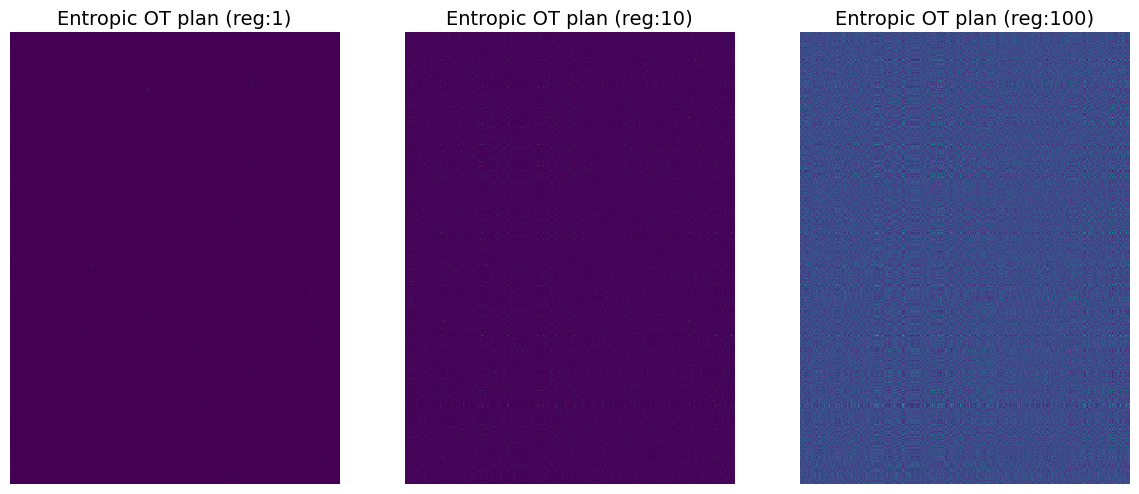

In [10]:
reg_list = [1, 10, 100]

plt.figure(figsize=(12, 5))
ot_plan_list = []

for i, reg in enumerate(reg_list):
    ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)
    entropic_ot_plan = ot_sampler.get_map(X_tensor, Y_tensor)
    ot_plan_list.append(entropic_ot_plan)

for i, reg in enumerate(reg_list):
    plt.subplot(1, 3, i + 1)
    plt.imshow(ot_plan_list[i], interpolation="nearest")
    plt.axis("off")
    plt.title("Entropic OT plan (reg:{})".format(reg), fontsize=14)

plt.tight_layout()
plt.show()

5000: loss 0.032
Sinkhorn distance - Entropic-OT plan (reg=1): 7.83
5000: loss 0.060
Sinkhorn distance - Entropic-OT plan (reg=10): 9.20


<timed exec>:63: UserWarning: The figure layout has changed to tight


5000: loss 0.057
Sinkhorn distance - Entropic-OT plan (reg=100): 9.80
CPU times: total: 7h 34min 5s
Wall time: 4h 3min 19s


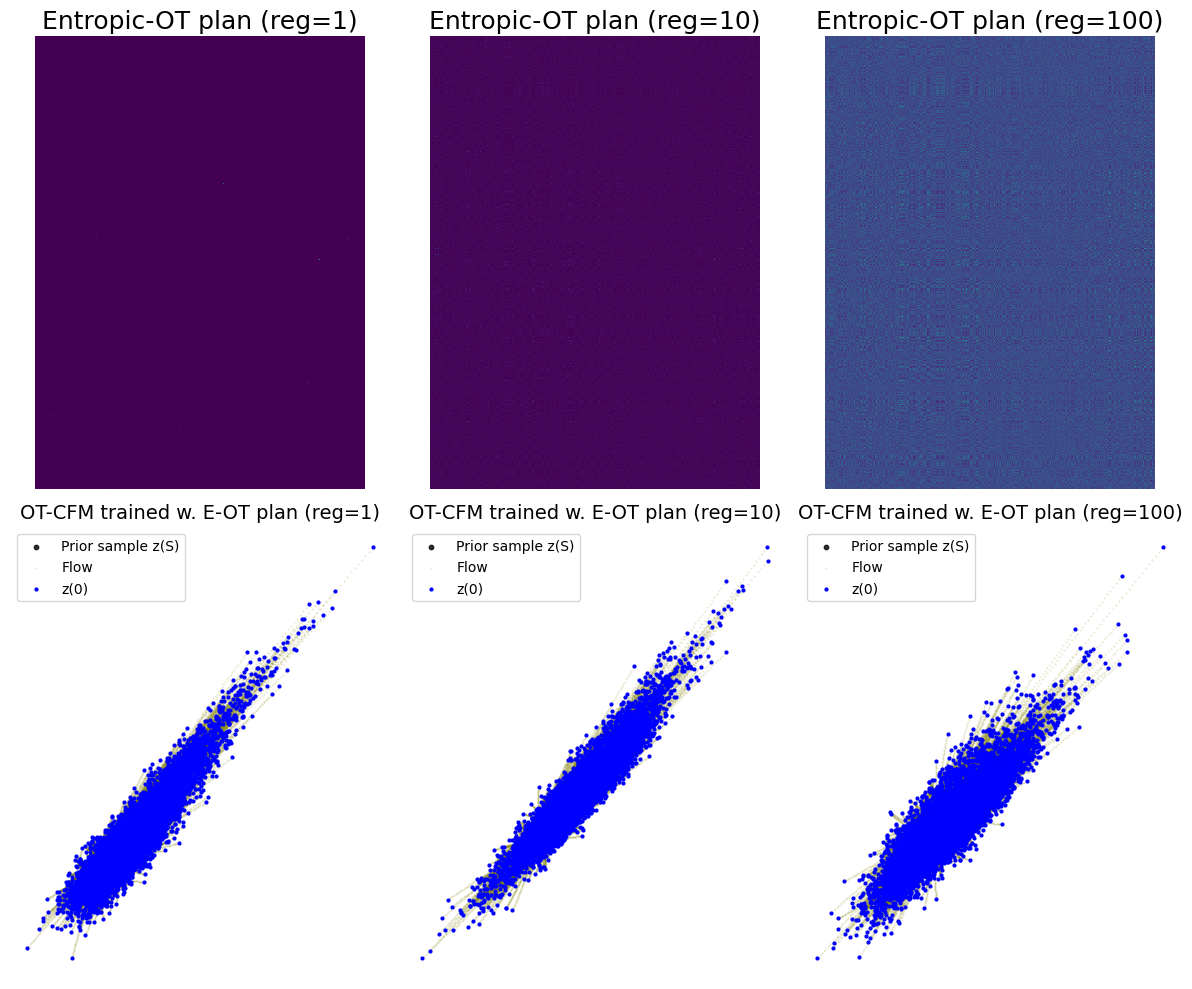

In [15]:
%%time
sigma = 0.1
dim = X_tensor.shape[1]
batch_size = 128
list_transported_samples_sbcfm = []

plt.figure(3, figsize=(12, 10))

for i, reg in enumerate(reg_list):
    model = MLP(dim=dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)

    ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)

    pi = ot_sampler.get_map(X_tensor, Y_tensor)

    for k in range(n_epochs):
        optimizer.zero_grad()

        indices_i, indices_j = ot_sampler.sample_map(pi, batch_size=batch_size, replace=False)
        batch_x0, batch_x1 = X_tensor[indices_i], Y_tensor[indices_j]

        t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)

        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    print(f"{k+1}: loss {loss.item():0.3f}")
    node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            X_tensor,
            t_span=torch.linspace(0, 1, 100),
        )

        sinkhorn_div = sinkhorn_loss(jnp.array(traj[-1].detach().numpy()), Y)
        print(f"Sinkhorn distance - Entropic-OT plan (reg={reg}): {sinkhorn_div:.2f}")

        plt.subplot(2, 3, i + 1)
        plt.imshow(ot_plan_list[i], interpolation="nearest")
        plt.axis("off")
        plt.title("Entropic-OT plan (reg={})".format(reg), fontsize=18)

        plt.subplot(2, 3, i + 4)
        traj = traj.cpu().numpy()
        list_transported_samples_sbcfm.append(traj[-1])
        plt.scatter(
            traj[0, :X.shape[0], 0], traj[0, :X.shape[0], 1], s=10, alpha=0.8, c="black"
        )
        plt.scatter(
            traj[:, :X.shape[0], 0], traj[:, :X.shape[0], 1], s=0.2, alpha=0.2, c="olive"
        )
        plt.scatter(traj[-1, :X.shape[0], 0], traj[-1, :X.shape[0], 1], s=4, alpha=1, c="blue")
        plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
        plt.title("OT-CFM trained w. E-OT plan (reg={})".format(reg), fontsize=14)
        plt.tight_layout()

In [17]:
for i, transported_samples in enumerate(list_transported_samples_sbcfm):
    clf = SVC()
    clf.fit(transported_samples, labels_mnist)
    labels_usps_pred = clf.predict(img_usps)

    if i == 0:
        print("Accuracy: {} - OT-CFM trained w. E-OT plan (reg=1)".format(accuracy_score(labels_usps, labels_usps_pred)))
        print("Balanced accuracy: {} - OT-CFM trained w. E-OT plan (reg=1)".format(balanced_accuracy_score(labels_usps, labels_usps_pred)))
    
    elif i == 1:
        print("Accuracy: {} - OT-CFM trained w. E-OT plan (reg=10)".format(accuracy_score(labels_usps, labels_usps_pred)))
        print("Balanced accuracy: {} - OT-CFM trained w. E-OT plan (reg=10)".format(balanced_accuracy_score(labels_usps, labels_usps_pred)))
    else:
        print("Accuracy: {} - OT-CFM trained w. E-OT plan (reg=100)".format(accuracy_score(labels_usps, labels_usps_pred)))
        print("Balanced accuracy: {} - OT-CFM trained w. E-OT plan (reg=100)".format(balanced_accuracy_score(labels_usps, labels_usps_pred)))

Accuracy: 0.6241942120422439 - OT-CFM trained w. E-OT plan (reg=1)
Balanced accuracy: 0.6040471317421412 - OT-CFM trained w. E-OT plan (reg=1)
Accuracy: 0.4788094911534769 - OT-CFM trained w. E-OT plan (reg=10)
Balanced accuracy: 0.4472110050326166 - OT-CFM trained w. E-OT plan (reg=10)
Accuracy: 0.47414620765327115 - OT-CFM trained w. E-OT plan (reg=100)
Balanced accuracy: 0.4544084954555558 - OT-CFM trained w. E-OT plan (reg=100)
